In [118]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from Dataset import Dataset, ELM, device
import plotly.graph_objects as go
torch.set_default_dtype(torch.float64)

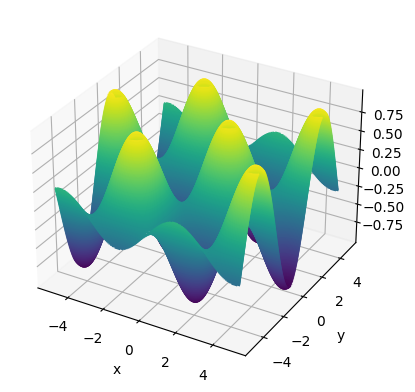

In [119]:
num_of_samples = 100
x_data = np.float64(np.linspace(-5, 5, num_of_samples))
y_data = np.float64(np.linspace(-5, 5, num_of_samples))

X, Y = np.meshgrid(x_data, y_data)
Z = np.sin(X)*np.cos(Y)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.contour3D(X, Y, Z, 200)
plt.show()

In [120]:
dataset = Dataset(np.concatenate((X.reshape(-1, 1), Y.reshape(-1, 1)), axis=1), Z.reshape(-1, 1))
trainset1, trainset2, testset = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1])

activation = nn.Sigmoid()
def inv_activation(x):
    return torch.log(x / (1 - x))

In [121]:
model = ELM(2, 100, 1).to(device)

V = activation(model.fc1.bias.data.reshape(-1, 1) + model.fc1.weight.data @ trainset1[:][0].T.to(device))
H = torch.concatenate([torch.ones(1, len(trainset1)).to(device), V.to(device)], dim=0).T
W2 = torch.linalg.pinv(H) @ trainset1[:][1].to(device).reshape(1, -1, 1)
model.fc2.bias.data, model.fc2.weight.data = W2[0][0], W2[0][1:].T

V = inv_activation(torch.linalg.pinv(model.fc2.weight.data) @ (trainset2[:][1].reshape(1, -1).to(device)-model.fc2.bias.data.reshape(-1, 1)))
H = torch.concatenate([torch.ones(1, len(trainset2)).to(device), trainset2[:][0].T.to(device)], dim=0)
W1 = V @ torch.linalg.pinv(H)
# W1 = V @ torch.inverse(H.T @ H + 1e-3*torch.eye(H.shape[1]).to(device)) @ H.T
model.fc1.bias.data, model.fc1.weight.data = W1[:, 2], W1[:, 0:2].reshape(-1, 2)

Train error: nan
Test error: nan


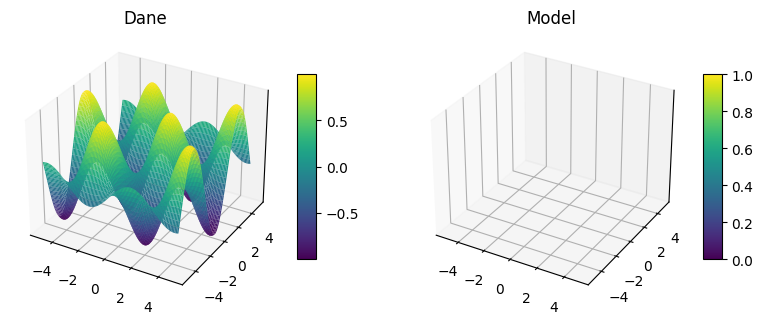

In [122]:
print(f'Train error: {(model(trainset1[:][0].clone().detach().to(device))-trainset1[:][1].reshape(-1, 1).to(device)).reshape(-1).pow(2).mean()}')
print(f'Test error: {(model(testset[:][0].clone().detach().to(device))-testset[:][1].reshape(-1, 1).to(device)).reshape(-1).pow(2).mean()}')
X, Y = np.meshgrid(x_data, y_data)
fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis')
ax.set_zticks([])
ax.set_title('Dane')
fig.colorbar(surf, shrink=0.5, aspect=10)

ax = fig.add_subplot(1, 2, 2, projection='3d')
surf = ax.plot_surface(X, Y, model(torch.cat((torch.Tensor(X).reshape(-1, 1), torch.Tensor(Y).reshape(-1, 1)), axis=1).to(device)).cpu().detach().numpy().reshape(num_of_samples, num_of_samples), rstride=1, cstride=1, cmap='viridis')
ax.set_zticks([])
ax.set_title('Model')
fig.colorbar(surf, shrink=0.5, aspect=10)

plt.show()

In [125]:
predictions = model(torch.cat((torch.Tensor(X).reshape(-1, 1), torch.Tensor(Y).reshape(-1, 1)), axis=1).to(device)).cpu().detach().numpy().reshape(-1)
trace1 = go.Scatter3d(
    x=X.reshape(-1),
    y=Y.reshape(-1),
    z=Z.reshape(-1),
    mode='markers',
    marker=dict(
        size=2,
        color=Z.reshape(-1),
        colorscale='Viridis',
        colorbar=dict(title='Data - predicitions'),
    ),
    name='Model'
)
fig = go.Figure(data=[trace1], layout=dict(width=700, height=500))
# fig.update_layout(
#     scene = dict(
#         xaxis = dict(range=[-5,5]),
#         yaxis = dict(range=[-5,5]),
#         zaxis = dict(range=[-0.1,0.1]),),
#     width=700,
#     margin=dict(r=20, l=10, b=10, t=10)
# )
fig.show()

array([nan, nan, nan, ..., nan, nan, nan])

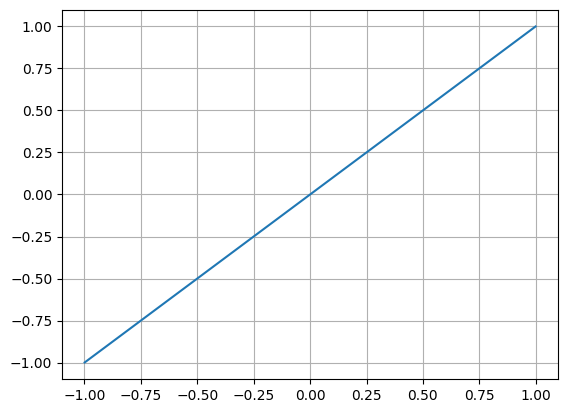

In [126]:
plt.plot([np.min(Z), np.max(Z)], [np.min(Z), np.max(Z)])
plt.plot(Z.reshape(-1), model(torch.cat((torch.Tensor(X).reshape(-1, 1), torch.Tensor(Y).reshape(-1, 1)), axis=1).to(device)).cpu().detach().numpy().reshape(-1), '.', markersize=1)
plt.grid()
plt.show()